# Transformation Tutorial

### Mechanism

1. Each transformation is a class with a callable function. An example is as follows

```python
class ToCHWImage(object):
    """ convert hwc image to chw image
    required keys: image
    modified keys: image
    """

    def __init__(self, **kwargs):
        pass

    def __call__(self, data: dict):
        img = data['image']
        if isinstance(img, Image.Image):
            img = np.array(img)
        data['image'] = img.transpose((2, 0, 1))
        return data
```

2. The input for transformation is always a dict, which contain data info like img_path, raw label, etc. 

3. The transformation api should have clarify the required keys in input and the modified or/and added keys in output the data dict.

Available transformations can be checked in `mindocr/data/transforms/*_transform.py`

In [438]:
# import and check available transforms

from mindocr.data.transforms import general_transforms, det_transforms, rec_transforms

In [4]:
general_transforms.__all__

['DecodeImage', 'NormalizeImage', 'ToCHWImage', 'PackLoaderInputs']

In [5]:
det_transforms.__all__

['DetLabelEncode',
 'MakeBorderMap',
 'MakeShrinkMap',
 'EastRandomCropData',
 'PSERandomCrop']

### Text detection

### 1. Load image and annotations

#### Preparation

In [28]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [416]:
import os

# load the label file which has the info of image path and annotation. 
# This file is generated from the ic15 annotations using the converter script.
label_fp = '/Users/Samit/Data/datasets/ic15/det/train/train_icdar2015_label.txt'
root_dir = '/Users/Samit/Data/datasets/ic15/det/train'

data_lines = []
with open(label_fp, 'r') as f:
    for line in f:
        data_lines.append(line)

# just pick one image and its annotation
idx = 3
img_path, annot = data_lines[idx].strip().split('\t')

img_path = os.path.join(root_dir, img_path)
print('img_path', img_path)
print('raw annotation: ', annot)



img_path /Users/Samit/Data/datasets/ic15/det/train/ch4_training_images/img_612.jpg
raw annotation:  [{"transcription": "where", "points": [[483, 197], [529, 174], [530, 197], [485, 221]]}, {"transcription": "people", "points": [[531, 168], [607, 136], [608, 166], [532, 198]]}, {"transcription": "meet", "points": [[613, 128], [691, 100], [691, 131], [613, 160]]}, {"transcription": "###", "points": [[695, 299], [888, 315], [931, 635], [737, 618]]}, {"transcription": "###", "points": [[709, 19], [876, 8], [880, 286], [713, 296]]}, {"transcription": "###", "points": [[530, 270], [660, 246], [661, 300], [532, 324]]}, {"transcription": "###", "points": [[113, 356], [181, 359], [180, 387], [112, 385]]}, {"transcription": "###", "points": [[281, 328], [369, 338], [366, 361], [279, 351]]}, {"transcription": "###", "points": [[66, 314], [183, 313], [183, 328], [68, 330]]}]


#### Decode the image  -  DecodeImage

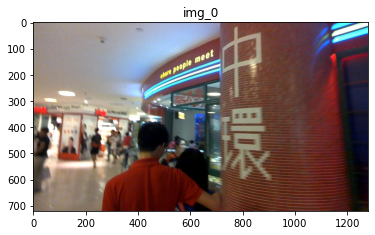

In [417]:
#img_path = '/Users/Samit/Data/datasets/ic15/det/train/ch4_training_images/img_1.jpg'
decode_image = general_transforms.DecodeImage(img_mode='BGR')

# TODO: check the input keys and output keys for the trans. func.

data = {'img_path': img_path}
data  = decode_image(data)
img = data['image']

# visualize
from mindocr.utils.visualize import show_img, show_imgs
show_img(img)

In [418]:
import time

start = time.time()
att = 100
for i in range(att):
    img  = decode_image(data)['image']
avg = (time.time() - start) / att

print('avg reading time: ', avg)

avg reading time:  0.004545390605926514


#### DetLabelEncode

['where', 'people', 'meet', '###', '###', '###', '###', '###', '###']


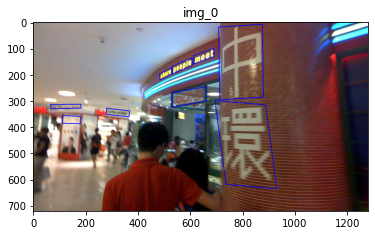

In [419]:
data['label'] = annot

decode_image = det_transforms.DetLabelEncode()
data = decode_image(data)

#print(data['polys'])
print(data['texts'])

# visualize
from mindocr.utils.visualize import draw_bboxes

res = draw_bboxes(data['image'], data['polys'])
show_img(res)


### 2. Image and annotation processing/augmentation

#### RandomCrop - EastRandomCropData

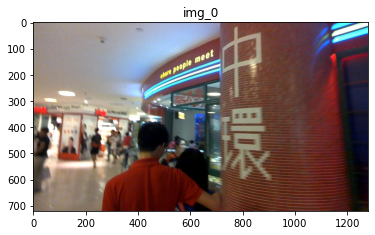

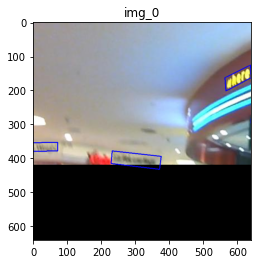

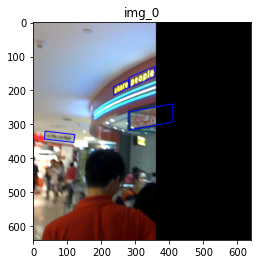

In [436]:
from mindocr.data.transforms.general_transforms import RandomCropWithBBox
import copy

#crop_data = det_transforms.EastRandomCropData(size=(640, 640))
crop_data = RandomCropWithBBox(crop_size=(640, 640))

show_img(data['image'])
for i in range(2):
    data_cache = copy.deepcopy(data)
    data_cropped = crop_data(data_cache)

    res_crop = draw_bboxes(data_cropped['image'], data_cropped['polys'])
    show_img(res_crop)

#### ColorJitter

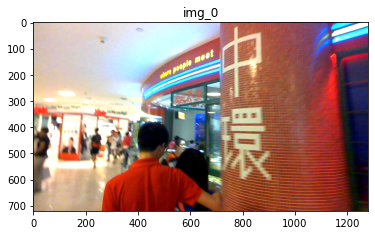

In [526]:
random_color_adj = general_transforms.RandomColorAdjust(brightness=0.4, saturation=0.5)

data_cache = copy.deepcopy(data)
#data_cache['image'] = data_cache['image'][:,:, ::-1]
data_adj = random_color_adj(data_cache)
#print(data_adj)
show_img(data_adj['image'], is_bgr_img=True)